## Glucocorticoid receptor - part 4 (library enumeration)

### Import libraries

In [1]:
import pandas as pd

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

import sys
sys.path.append('/home/daniel/wizepair2')
from mmpa.chem import strip_stereo

from rdkit import Chem

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### Read in the datasets

In [2]:
df = pd.read_csv('nr3c1_agonists_stripped.csv')
df_trans = pd.read_csv('nr3c1_agonists_transformations.csv')

### Take cortisol as only seed

In [3]:
df = df[df.stripped_smiles=='C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C@@H]1CC[C@]2(O)C(=O)CO']

### Merge on assay identifier to enumerate all seed molecule / transformation pairs

In [4]:
df = df[pd.notna(df.pchembl_value)]

### Apply the transformations

In [5]:
def apply_reaction(smiles, smirks):
    rxn = Chem.rdChemReactions.ReactionFromSmarts(smirks)
    productset = rxn.RunReactants((Chem.AddHs(Chem.MolFromSmiles(smiles)),))
    productlist = list()
    for product in productset:
        productlist.append('.'.join([Chem.MolToSmiles(Chem.RemoveHs(productpart)) for productpart in product]))
    return list(set(productlist))

In [6]:
def enumerate_recursive(df: pd.DataFrame(), df_trans: pd.DataFrame(), generations=1):
    
    if generations > 0: 
    
        df = df.merge(df_trans, on=['target_pref_name', 'standard_type'])
        df_product = df.sample(frac=1).parallel_apply(lambda x: apply_reaction(x.stripped_smiles, x.smirks), axis=1)

        df_product = df.join(pd.DataFrame(df_product.explode(), columns=['products']))
        df_product = df_product[pd.notna(df_product.products)]
        
        if 'last_smiles' in df_product: df_product.last_smiles = df_product.last_smiles + '.' + df_product.stripped_smiles
        else: df_product['last_smiles'] = df_product.stripped_smiles
        df_product.stripped_smiles = df_product.products
        df_product.pchembl_value = df_product.pchembl_value + df_product.mean_pchembl_exact_delta
        
        df_product = pd.pivot_table(df_product, values='pchembl_value', index=[
            'last_smiles', 'stripped_smiles', 'target_pref_name', 'standard_type'], aggfunc='mean').reset_index()
        df_product['generation'] = generations
        
        df_product['achiral_smiles'] = df_product.stripped_smiles.apply(strip_stereo)
        if 'CCCC1OC2CC3C4CCC5=CC(=O)C=CC5(C)C4C(O)CC3(C)C2(C(=O)CO)O1' in df_product.achiral_smiles.to_list(): print('hit!')

        generations -= 1
        yield df_product
        yield from enumerate_recursive(df_product, df_trans, generations)


In [7]:
df_products = enumerate_recursive(df, df_trans, 3)

In [8]:
df_products = pd.concat([x for x in df_products])

In [9]:
df_products.groupby('stripped_smiles').count().sort_values('generation')

,last_smiles,target_pref_name,standard_type,pchembl_value,generation,achiral_smiles
stripped_smiles,,,,,,
CC(=O)C1(O)C(C)C[C@@H]2[C@H]3CCC4=CC(=O)CCC4(C)[C@@]3(F)[C@@H](O)CC21C,1,1,1,1,1,1
C[C@]12CCC(=O)C=C1CC[C@@H]1[C@@H]2[C@@H](O)C[C@]2(C)[C@H]1CC[C@]2(O)C(=O)COC(=O)CCC(=O)O,1,1,1,1,1,1
C[C@]12CCC(=O)C=C1CC[C@@H]1[C@@H]2[C@@H](O)C[C@]2(C)[C@H]1CC[C@]2(O)C(=O)COC(=O)C1CCCC1,1,1,1,1,1,1
C[C@]12CCC(=O)C=C1CC[C@@H]1[C@@H]2[C@@H](O)C[C@]2(C)[C@H]1CC[C@H]2C(=O)COC(=O)C1CCCC1,1,1,1,1,1,1
C[C@]12CCC(=O)C=C1CC[C@@H]1[C@@H]2[C@@H](O)C[C@]2(C)[C@H]1CC[C@H]2C(=O)COC(=O)C1(O)CCCC1,1,1,1,1,1,1
...,...,...,...,...,...,...
C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C@@H]1CC[C@]2(O)C(=O)CSc1nc2ccccc2o1,475,475,475,475,475,475
C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C@@H]1CC[C@]2(O)C(=O)CSc1ccc2ccccc2n1,477,477,477,477,477,477
C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C@@H]1CC[C@]2(O)C(=O)CSc1nc2ncccc2o1,489,489,489,489,489,489


In [10]:
df_holdout = pd.read_csv('nr3c1_agonists_stripped_holdout.csv')

In [11]:
df_holdout = df_holdout.merge(df_products, on=['stripped_smiles', 'target_pref_name', 'standard_type'])

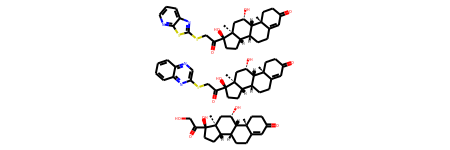

In [12]:
Chem.MolFromSmiles(df_products.sample(1).last_smiles.to_list()[0])

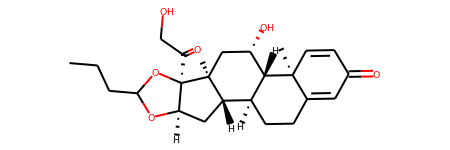

In [13]:
Chem.MolFromSmiles('CCCC1O[C@@H]2C[C@H]3[C@@H]4CCC5=CC(=O)C=C[C@]5(C)[C@H]4[C@@H](O)C[C@]3(C)[C@]2(C(=O)CO)O1')

### Write to file

In [14]:
df_products = df_products.reset_index()
df_products.to_csv('nr3c1_agonists_products.csv', index=False)